<a href="https://colab.research.google.com/github/rnvllflores/tutorials/blob/main/samgeo_fishpen_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping Fishpen Polygons Using sam-geospatial

This tutorial is just an adaptation of Quisheng Wu's samples on how to implement sam-geospatial.

It uses fishpens in Laguna de Bay as the target objects to segment. Getting fishpen geometries is important in managing the lake's resources which involves:
- Finding newly built fishpens 
- Monitoring the total hectarage of fishpens across the lake
- Ensuring that fishpens follow prescribed building codes

Having an accessible way to detect and map fishpens across large areas and being able to integrate it in a geospatial database can have huge workflow impact in lake management


**Usage note**: When running on colab, change runtime type to GPU. Click Runtime > Change Runtime type > select GPU

# Set Up

## Installation and Imports

In [ ]:
%pip install segment-geospatial leafmap localtileserver geopandas

In [2]:
import os
import leafmap
import geopandas as gpd
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [3]:
out_dir = os.path.join(os.path.expanduser("~"), "Downloads")
checkpoint = os.path.join(out_dir, "sam_vit_h_4b8939.pth")

In [4]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [5]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=sam_kwargs,
)

Checkpoint /root/Downloads/sam_vit_h_4b8939.pth does not exist.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/Downloads/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:27<00:00, 94.7MB/s]


# Select Fishpond Area

In [6]:
m = leafmap.Map(center=[14.4216363,121.0874963], zoom=16, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[14.4216363, 121.0874963], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [7]:
bbox = m.user_roi_bounds()

In [8]:
bbox

[121.0807, 14.4175, 121.0966, 14.4276]

## Downlaod image

In [9]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/30
Downloaded image 2/30
Downloaded image 3/30
Downloaded image 4/30
Downloaded image 5/30
Downloaded image 6/30
Downloaded image 7/30
Downloaded image 8/30
Downloaded image 9/30
Downloaded image 10/30
Downloaded image 11/30
Downloaded image 12/30
Downloaded image 13/30
Downloaded image 14/30
Downloaded image 15/30
Downloaded image 16/30
Downloaded image 17/30
Downloaded image 18/30
Downloaded image 19/30
Downloaded image 20/30
Downloaded image 21/30
Downloaded image 22/30
Downloaded image 23/30
Downloaded image 24/30
Downloaded image 25/30
Downloaded image 26/30
Downloaded image 27/30
Downloaded image 28/30
Downloaded image 29/30
Downloaded image 30/30
Saving GeoTIFF. Please wait...
Image saved to satellite3.tif


In [10]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=7709700.0, center=[14.42162980062478, 121.08748912811281], controls=(ZoomControl(options=['position…

## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object. 

In [11]:
sam.generate(image, output="masks.tif", foreground=True)

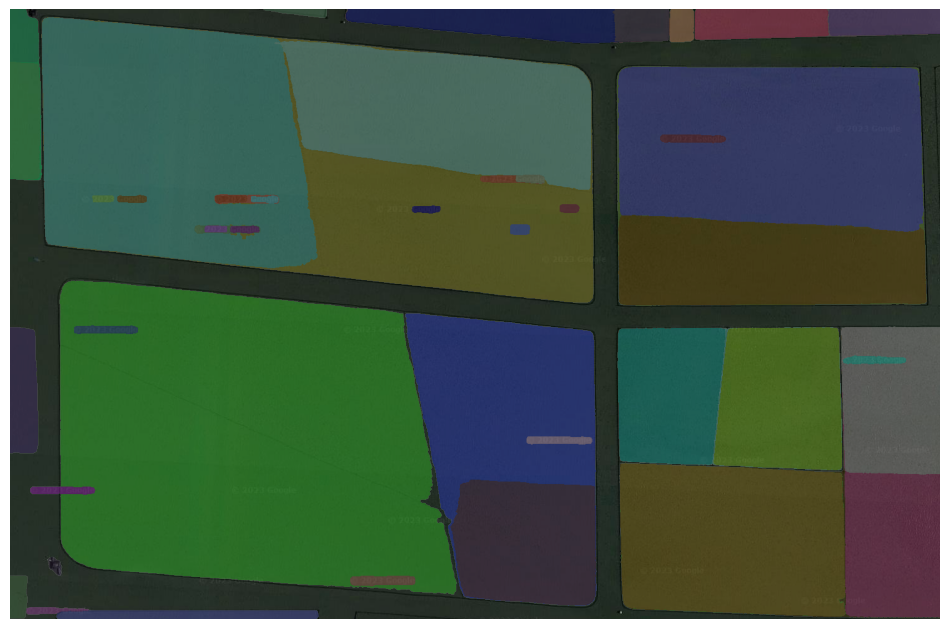

In [12]:
sam.show_anns(axis="off", opacity=1, output="annotations.tif")

### Compare images with a slider.


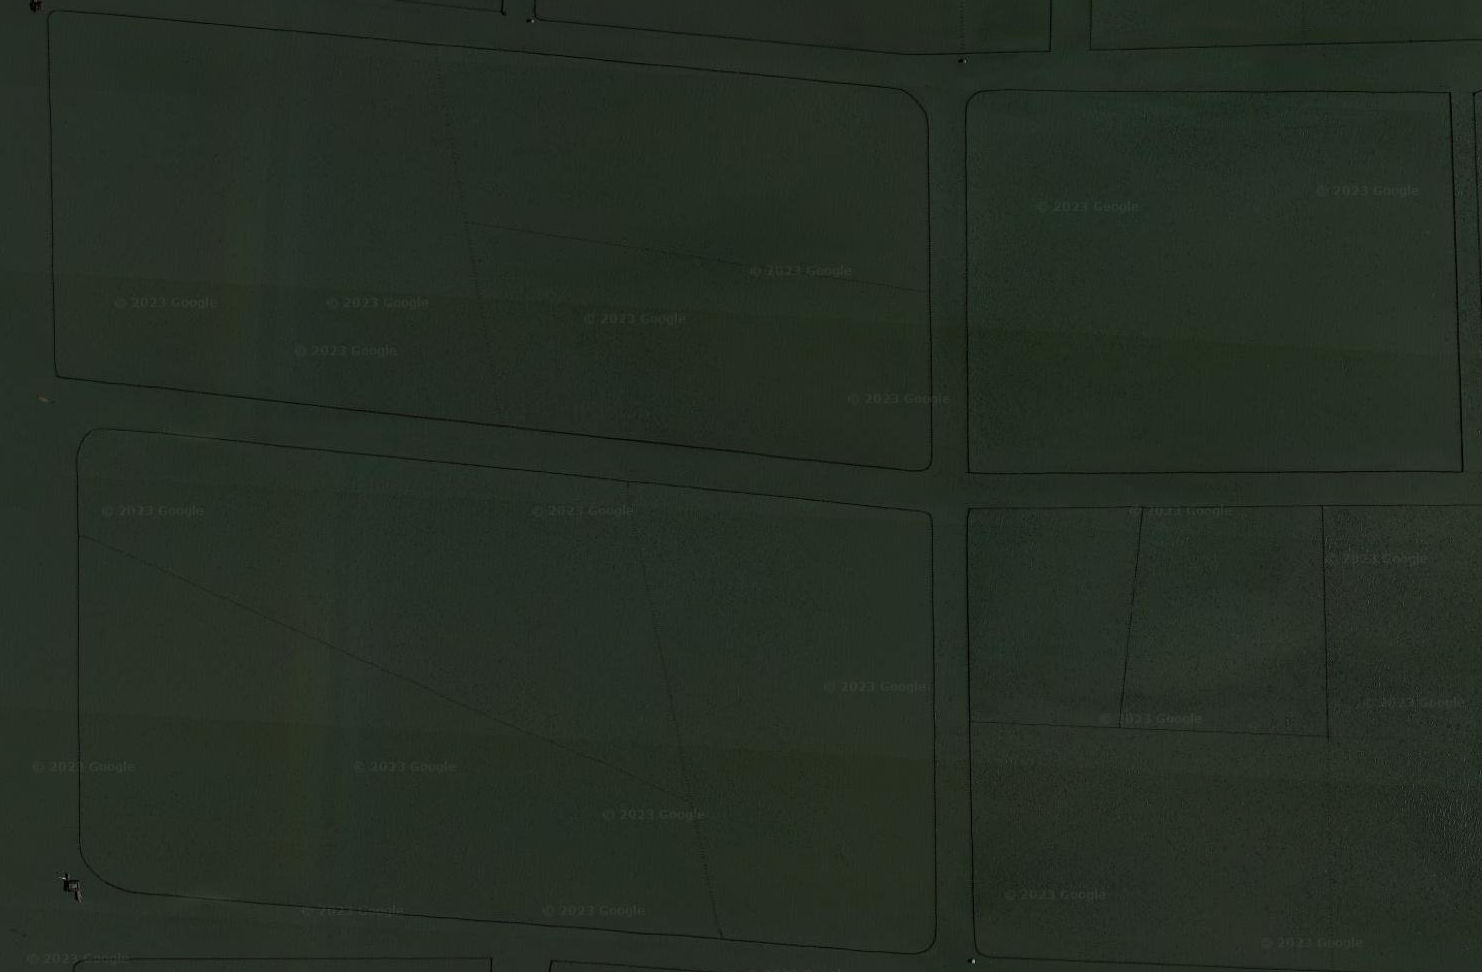
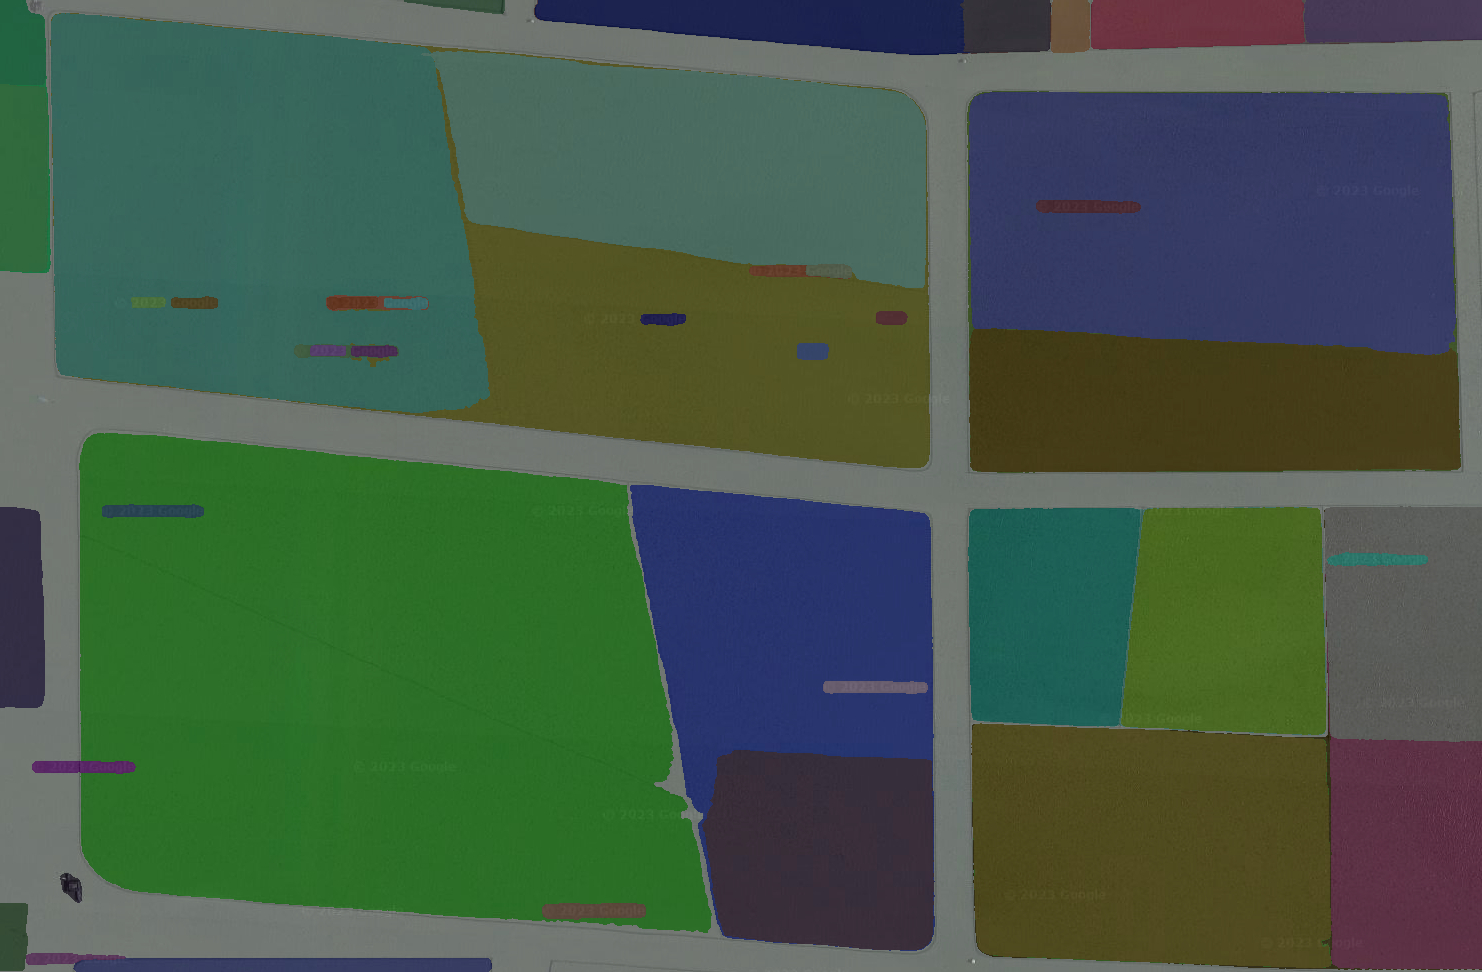

In [14]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

In [15]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

# Calculate fishpen area using geopandas

In [16]:
fishpens = gpd.read_file('masks.gpkg', crs = 'EPSG:4326')

In [17]:
fishpens['area_m'] = fishpens.to_crs('EPSG:3123').area

In [18]:
fishpens.to_crs('EPSG:3123').area.sum()/10000

158.73691795417642